In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
repo_root = Path().resolve().parent
sys.path.insert(0, str(repo_root))
from tools import time_of_day

df = pd.read_csv("../data/Traffic_Crashes_Resulting_in_Fatality.csv")

df.head()


,unique_id,case_id_fkey,latitude,longitude,collision_year,death_date,death_time,death_datetime,collision_date,collision_time,...,in_coc_2018,publish,on_vz_hin_2022,in_epa_2021,point,analysis_neighborhood,supervisor_district,police_district,data_as_of,data_loaded_at
0,1,140236301,37.710409,-122.404226,2014,2014/03/20,11:21:00,2014/03/20 11:21:00 AM,2014/03/20,NaN,...,False,True,True,False,POINT (-122.404226037 37.710409217),Bayview Hunters Point,10.0,INGLESIDE,2024/09/18 12:00:00 AM,2025/11/06 10:51:39 AM
1,2,140755533,37.725476,-122.394243,2014,2014/09/08,16:38:00,2014/09/08 04:38:00 PM,2014/09/08,05:10:00,...,True,True,True,True,POINT (-122.394243493 37.72547565),Bayview Hunters Point,10.0,BAYVIEW,2024/09/18 12:00:00 AM,2025/11/06 10:51:39 AM
2,4,140365546,37.748255,-122.413669,2014,2014/05/03,17:20:00,2014/05/03 05:20:00 PM,2014/05/03,02:24:00,...,False,True,True,False,POINT (-122.413668844 37.748255329),Mission,9.0,MISSION,2024/09/18 12:00:00 AM,2025/11/06 10:51:39 AM
3,16,150562049,37.777300,-122.419694,2015,2015/06/30,06:00:00,2015/06/30 06:00:00 AM,2015/06/28,03:52:00,...,False,True,True,True,POINT (-122.419693566 37.777299856),Tenderloin,5.0,NORTHERN,2024/09/18 12:00:00 AM,2025/11/06 10:51:39 AM
4,17,140104811,37.778251,-122.419883,2014,2014/02/06,10:20:00,2014/02/06 10:20:00 AM,2014/02/05,02:26:00,...,False,True,True,True,POINT (-122.419883231 37.778251017),Hayes Valley,5.0,NORTHERN,2024/09/18 12:00:00 AM,2025/11/06 10:51:39 AM


In [2]:

df.shape


(345, 28)

In [3]:
df.columns


Index(['unique_id', 'case_id_fkey', 'latitude', 'longitude', 'collision_year',
       'death_date', 'death_time', 'death_datetime', 'collision_date',
       'collision_time', 'collision_datetime', 'location', 'age', 'sex',
       'deceased', 'collision_type', 'street_type', 'on_vz_hin_2017',
       'in_coc_2018', 'publish', 'on_vz_hin_2022', 'in_epa_2021', 'point',
       'analysis_neighborhood', 'supervisor_district', 'police_district',
       'data_as_of', 'data_loaded_at'],
      dtype='object')

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unique_id              345 non-null    int64  
 1   case_id_fkey           338 non-null    object 
 2   latitude               345 non-null    float64
 3   longitude              345 non-null    float64
 4   collision_year         345 non-null    int64  
 5   death_date             345 non-null    object 
 6   death_time             311 non-null    object 
 7   death_datetime         345 non-null    object 
 8   collision_date         345 non-null    object 
 9   collision_time         320 non-null    object 
 10  collision_datetime     345 non-null    object 
 11  location               345 non-null    object 
 12  age                    344 non-null    float64
 13  sex                    345 non-null    object 
 14  deceased               345 non-null    object 
 15  collis

In [5]:
df.select_dtypes(include='number').describe()


,unique_id,latitude,longitude,collision_year,age,supervisor_district
count,3.450000e+02,345.000000,345.000000,345.000000,344.000000,344.000000
mean,1.319810e+07,37.762547,-122.428598,2019.594203,52.531977,6.284884
std,1.090101e+08,0.027374,0.030388,3.463761,20.924663,3.030497
min,1.000000e+00,37.708628,-122.513360,2014.000000,0.000000,1.000000
25%,1.140000e+02,37.741162,-122.442648,2016.000000,34.000000,4.000000
50%,2.750000e+02,37.769586,-122.419714,2020.000000,53.000000,6.000000
75%,2.023001e+07,37.783785,-122.407587,2023.000000,68.000000,9.000000
max,2.024040e+09,37.823175,-122.370075,2025.000000,95.000000,11.000000


# Data Overview

In this notebook, I (Zhanna) will do:

- Data cleaning for the traffic fatality dataset.
- Part 1: Death trends (by year, month, and time of day).

From the initial inspection:

- The dataset has `345` rows and `28` columns.
- Important time-related columns include `collision_date`, `collision_time`, and `collision_datetime`.
- I will use `collision_datetime` to define when the fatal crash occurred.


In [6]:
# Convert date and datetime columns to proper datetime format

date_columns = [
    'death_date', 'death_datetime',
    'collision_date', 'collision_datetime',
    'data_as_of', 'data_loaded_at'
]

for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

df.head()


/tmp/ipykernel_7256/3247978513.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
/tmp/ipykernel_7256/3247978513.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


,unique_id,case_id_fkey,latitude,longitude,collision_year,death_date,death_time,death_datetime,collision_date,collision_time,...,in_coc_2018,publish,on_vz_hin_2022,in_epa_2021,point,analysis_neighborhood,supervisor_district,police_district,data_as_of,data_loaded_at
0,1,140236301,37.710409,-122.404226,2014,2014-03-20,11:21:00,2014-03-20 11:21:00,2014-03-20,NaN,...,False,True,True,False,POINT (-122.404226037 37.710409217),Bayview Hunters Point,10.0,INGLESIDE,2024-09-18,2025-11-06 10:51:39
1,2,140755533,37.725476,-122.394243,2014,2014-09-08,16:38:00,2014-09-08 16:38:00,2014-09-08,05:10:00,...,True,True,True,True,POINT (-122.394243493 37.72547565),Bayview Hunters Point,10.0,BAYVIEW,2024-09-18,2025-11-06 10:51:39
2,4,140365546,37.748255,-122.413669,2014,2014-05-03,17:20:00,2014-05-03 17:20:00,2014-05-03,02:24:00,...,False,True,True,False,POINT (-122.413668844 37.748255329),Mission,9.0,MISSION,2024-09-18,2025-11-06 10:51:39
3,16,150562049,37.777300,-122.419694,2015,2015-06-30,06:00:00,2015-06-30 06:00:00,2015-06-28,03:52:00,...,False,True,True,True,POINT (-122.419693566 37.777299856),Tenderloin,5.0,NORTHERN,2024-09-18,2025-11-06 10:51:39
4,17,140104811,37.778251,-122.419883,2014,2014-02-06,10:20:00,2014-02-06 10:20:00,2014-02-05,02:26:00,...,False,True,True,True,POINT (-122.419883231 37.778251017),Hayes Valley,5.0,NORTHERN,2024-09-18,2025-11-06 10:51:39


In [7]:
# Extract useful time components from collision_datetime

df['year'] = df['collision_datetime'].dt.year
df['month'] = df['collision_datetime'].dt.month
df['day'] = df['collision_datetime'].dt.day
df['hour'] = df['collision_datetime'].dt.hour
df['month_name'] = df['collision_datetime'].dt.month_name()

df[['year', 'month', 'day', 'hour']].head()


,year,month,day,hour
0,2014,3,20,0
1,2014,9,8,5
2,2014,5,3,2
3,2015,6,28,3
4,2014,2,5,2


In [8]:
# Define categorical time of day
df['time_of_day'] = df['hour'].apply(time_of_day)

df['time_of_day'].value_counts()


time_of_day
Night (00–05)        99
Evening (18–23)      92
Afternoon (12–17)    91
Morning (06–11)      63
Name: count, dtype: int64

In [9]:
df = df[(df['year'] >= 2014) & (df['year'] <= 2025)]
df['year'].value_counts().sort_index()


year
2014    30
2015    31
2016    29
2017    20
2018    23
2019    29
2020    30
2021    27
2022    39
2023    26
2024    42
2025    19
Name: count, dtype: int64

In [10]:
df.to_csv("../data/cleaned_fatality_data.csv", index=False)


In [11]:
# Load cleaned data for analysis
df = pd.read_csv("../data/cleaned_fatality_data.csv")


In [12]:
# Count number of fatal crashes per year
deaths_by_year = df.groupby("year").size().sort_index()
deaths_by_year


year
2014    30
2015    31
2016    29
2017    20
2018    23
2019    29
2020    30
2021    27
2022    39
2023    26
2024    42
2025    19
dtype: int64

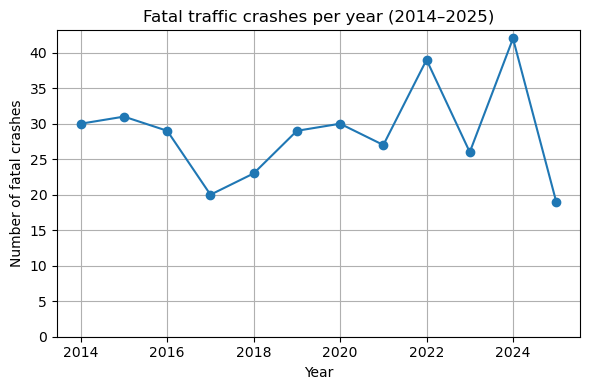

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
deaths_by_year.plot(kind="line", marker="o")
plt.xlabel("Year")
plt.ylabel("Number of fatal crashes")
plt.title("Fatal traffic crashes per year (2014–2025)")
plt.ylim(bottom=0)
plt.grid(True)
plt.tight_layout()

plt.savefig("../results/deaths_by_year.png", dpi=300)
plt.show()


### Death trends by year

This plot shows the number of fatal traffic crashes per year from 2014 to 2025.
The number of deaths varies from year to year, with noticeable increases in the most recent years.
The lower count in 2025 is likely because the year is incomplete in the dataset.


In [14]:
# Count number of fatal crashes per month (across all years)
deaths_by_month = df.groupby("month").size().sort_index()
deaths_by_month


month
1     24
2     23
3     39
4     17
5     34
6     31
7     24
8     33
9     30
10    30
11    27
12    33
dtype: int64

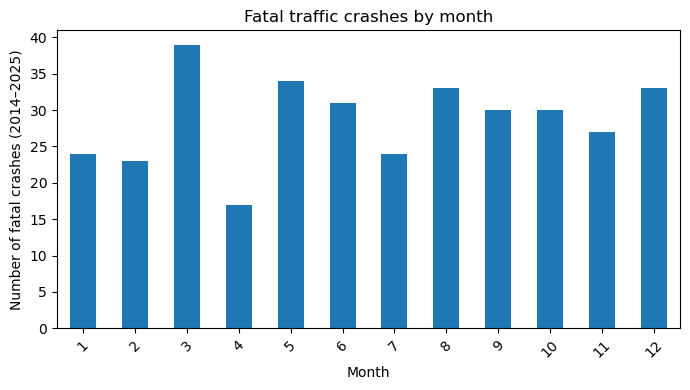

In [15]:
# Save monthly deaths plot
plt.figure(figsize=(7,4))
deaths_by_month.plot(kind="bar")
plt.xlabel("Month")
plt.ylabel("Number of fatal crashes (2014–2025)")
plt.title("Fatal traffic crashes by month")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("../results/deaths_by_month.png", dpi=300)
plt.show()


### Death trends by month

Fatal traffic crashes are not evenly distributed across the year.
Some months show higher numbers of fatal crashes than others, indicating possible seasonal patterns.
In particular, late winter/early spring and late summer months tend to have higher counts,
while some spring months show fewer fatal crashes.


In [16]:
# Count fatal crashes by time of day
deaths_by_time = df["time_of_day"].value_counts()
deaths_by_time


time_of_day
Night (00–05)        99
Evening (18–23)      92
Afternoon (12–17)    91
Morning (06–11)      63
Name: count, dtype: int64

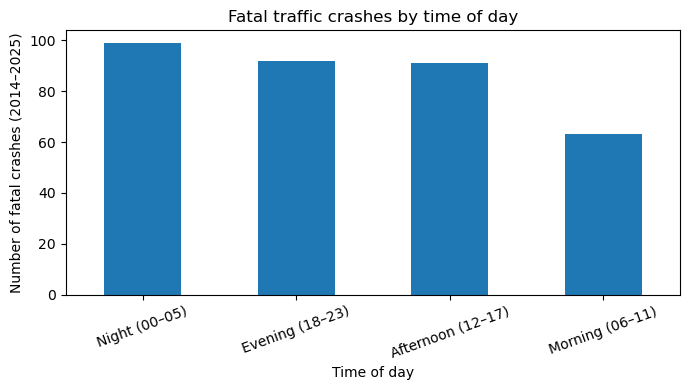

In [17]:
# Save time-of-day deaths plot
plt.figure(figsize=(7,4))
deaths_by_time.plot(kind="bar")
plt.xlabel("Time of day")
plt.ylabel("Number of fatal crashes (2014–2025)")
plt.title("Fatal traffic crashes by time of day")
plt.xticks(rotation=20)
plt.tight_layout()

plt.savefig("../results/deaths_by_time_of_day.png", dpi=300)
plt.show()


### Death trends by time of day

Fatal traffic crashes vary substantially by time of day.
The highest number of fatal crashes occurs during nighttime hours,
followed closely by the evening and afternoon.
Morning hours have the fewest fatal crashes.
This suggests that reduced visibility and nighttime driving conditions
may be associated with higher fatality risk.
